In [1]:
import io
import os
import os.path as osp

os.chdir(os.path.dirname(os.getcwd()))
from helpers import *
from configs import *
from google.cloud import vision
from tqdm import tqdm
from PIL import Image

print("Current directory: ", os.getcwd())

Current directory:  /home/ntnhu/projects/VideoFall-VBS2022


### Google API

In [1]:

# Path to the Credential json (download from GG)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/ntnhu/projects/VideoFall-VBS2022/OCR/vbs-ocr.json" 

def convert_response_to_list(res):
    texts = res.text_annotations
    result = []
    for text in texts:
        di = dict()
        di['text'] = text.description
        di['bb'] = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        result.append(di)
    return result

# Declare API
client = vision.ImageAnnotatorClient()

In [4]:
# Declare API
client = vision.ImageAnnotatorClient()

# Prepare path to a single image
img_id = 'shot07477_1_RKF'
path = f'/mnt/DEAKIN/VBS2022/keyframes/07477/{img_id}.png'
# Read image
# path = '/mnt/data/lsc2020/2015-02-23/b00000002_21i6bq_20150223_070809e.jpg'
with io.open(path, 'rb') as image_file:
    content = image_file.read()
image = vision.Image(content=content)

# Run API (its free 1000 times/month --> later 1.5 / 1000 calls)
response = client.text_detection(image=image)

In [11]:
img_id = 'shot07485_110_RKF'
path = f'/mnt/DEAKIN/VBS2022/keyframes/07485/{img_id}.png'

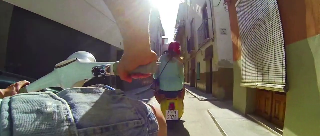

In [12]:
from PIL import Image

Image.open(path)

In [1]:
# response

### Provided V3C1-OCR

https://github.com/klschoef/V3C1Analysis

In [26]:
V3C1_OCR_path = '/mnt/DEAKIN/VBS2022/provided_ocr/V3C1_ocr'
allshots_filename = osp.join(V3C1_OCR_path, 'msb-allshots.txt')

In [27]:
with open(allshots_filename, 'r') as file:
    allshots = file.read().splitlines()
    allshots.pop(0)
    allshots = sort_list(allshots)

In [28]:
curr_video_idx = int(allshots[0][:5])
index = 1
for i, item in enumerate(tqdm(allshots)):
    video_idx = int(item[:5])
    if video_idx > curr_video_idx:
        index = 1
        curr_video_idx = video_idx
    allshots[i] = ';'.join([item, str(index)])
    index = index + 1

100%|████████████████████████████████████████████████| 1082657/1082657 [00:00<00:00, 1829209.55it/s]


In [29]:
allshots

['00001.mp4;0;127;63;1',
 '00001.mp4;128;133;130;2',
 '00001.mp4;134;146;140;3',
 '00001.mp4;147;157;152;4',
 '00001.mp4;158;199;178;5',
 '00001.mp4;200;249;224;6',
 '00001.mp4;250;261;255;7',
 '00001.mp4;262;289;275;8',
 '00001.mp4;290;334;312;9',
 '00001.mp4;335;341;338;10',
 '00001.mp4;342;355;348;11',
 '00001.mp4;356;371;363;12',
 '00001.mp4;372;375;373;13',
 '00001.mp4;376;390;383;14',
 '00001.mp4;391;403;397;15',
 '00001.mp4;404;472;438;16',
 '00001.mp4;473;534;503;17',
 '00001.mp4;535;554;544;18',
 '00001.mp4;555;615;585;19',
 '00001.mp4;616;625;620;20',
 '00001.mp4;626;643;634;21',
 '00001.mp4;644;649;646;22',
 '00001.mp4;650;682;666;23',
 '00001.mp4;683;696;689;24',
 '00001.mp4;697;755;726;25',
 '00001.mp4;756;864;810;26',
 '00001.mp4;865;883;874;27',
 '00001.mp4;884;885;884;28',
 '00001.mp4;886;904;895;29',
 '00001.mp4;905;916;910;30',
 '00001.mp4;917;950;933;31',
 '00001.mp4;951;1063;1007;32',
 '00001.mp4;1064;1159;1111;33',
 '00001.mp4;1160;1186;1173;34',
 '00001.mp4;1187;1

### Provided V3C2-OCR

https://github.com/lucaro/V3C2Analysis

In [ ]:

with open()

In [19]:

with open('csvfile.csv','wb') as file:
    for line in fewtext:
        print(line)
        file.write(line)
        file.write('\n')

00001/00001_0000348


TypeError: a bytes-like object is required, not 'str'

In [11]:
import csv

# open the file in the write mode
with open('abc.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(fewtext)